## IMPORTAR BIBLIOTECAS

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## CARGAR DATA

In [123]:
df=pd.read_csv('/Users/andrezaragozabonilla/Desktop/E-commerce/data.csv',encoding= 'unicode_escape')

In [124]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
339627,566601,22193,RED DINER WALL CLOCK,1,9/13/2011 15:57,8.50,16469.0,United Kingdom
403540,571636,20975,12 PENCILS SMALL TUBE RED RETROSPOT,24,10/18/2011 11:41,0.65,13509.0,United Kingdom
359471,568188,22544,MINI JIGSAW SPACEBOY,1,9/25/2011 14:33,0.42,16049.0,United Kingdom
375926,569487,22978,PANTRY ROLLING PIN,6,10/4/2011 12:55,3.75,13351.0,United Kingdom
136673,547967,85066,CREAM SWEETHEART MINI CHEST,1,3/28/2011 15:49,24.96,NaN,United Kingdom


## Conociendo la DATA

In [125]:
# Dimensiones del DataFrame
df.shape

(541909, 8)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [127]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [128]:
# Convertir la varaible InvoiceDate de tipo "objecto" a "datatime"
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [129]:
# Verificar que se realizó el cambio
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## Análisis de características

- **Dividir categoricas y númericas**

In [130]:
# Variables Categóricas
cat_var = df.select_dtypes(include=['object'])
cat_var.head()

,InvoiceNo,StockCode,Description,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [131]:
# Variables Númericas
num_var = df.select_dtypes(include=['int64', 'float64','datetime64[ns]'])
num_var.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID
0,6,2010-12-01 08:26:00,2.55,17850.0
1,6,2010-12-01 08:26:00,3.39,17850.0
2,8,2010-12-01 08:26:00,2.75,17850.0
3,6,2010-12-01 08:26:00,3.39,17850.0
4,6,2010-12-01 08:26:00,3.39,17850.0


## Manejo de Variables

In [132]:
# Se creara una copia de la data original
df_copy=df.copy()

In [133]:
# Comenzaremos por revisar los nulos
df_copy.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [134]:
# Se decide dropear los nulos porque:
# En el caso de Description es una cantidad poco representativa de los datos.
# En el caso de CustomerID, es un número único, es por eso que no se puede remplazar con las medias ni con la moda.
df_copy.dropna(inplace=True)

In [135]:
# Se elimina la columna InvoiceDate ya que no será relevante para el análisis.
df_copy=df_copy.drop(['InvoiceDate'], axis=1)

In [136]:
# Volvemos a revisar las dimensiones de nuestro Dataset
df_copy.shape

(406829, 7)

# Exploratory Data Analysis

In [137]:
# Empezamos por convertir la variable CustomerId de tipo "flotante" a "entero"
df_copy['CustomerID'] = df_copy['CustomerID'].astype(int)

### **Top 10 clientes con más compras**

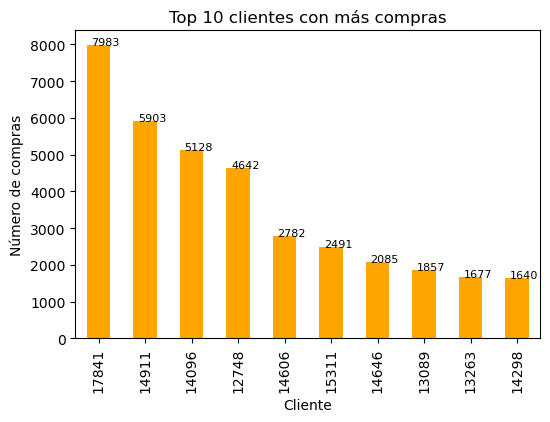

In [138]:
customer = df_copy['CustomerID'].value_counts().head(10).plot.bar(figsize=(6,4), color='orange')
customer.set_xlabel('Cliente')
customer.set_ylabel('Número de compras')
customer.set_title('Top 10 clientes con más compras')

for i in customer.patches:
    customer.text(i.get_x()+0.1, i.get_height()+1, str(i.get_height()), fontsize=8)


### **Cantidad promedio de compras por cliente**

In [139]:
# Agrupamos los datos por número de cliente y calcular el promedio de compras por cliente
average_purchases = df_copy.groupby("CustomerID")["Quantity"].mean()

print("La cantidad promedio de compras por cliente es:", round(average_purchases.mean(),2))

La cantidad promedio de compras por cliente es: 22.39


### **Ventas por mes** 

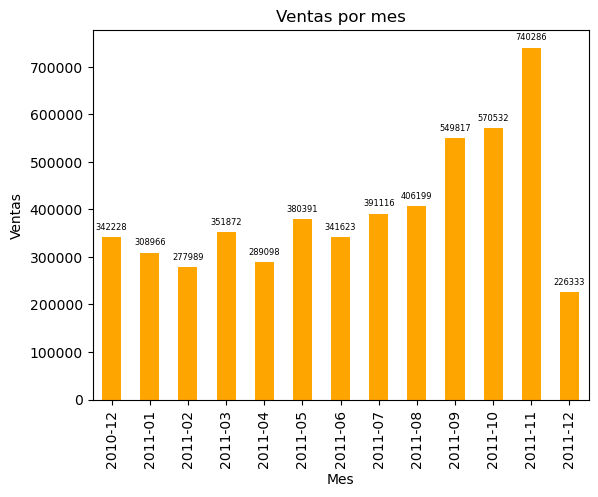

In [140]:
# Agrupamos las ventas por mes
sales_by_month = df.groupby(df['InvoiceDate'].dt.strftime('%Y-%m'))['Quantity'].sum()

# Se crea un gráfico de barras
ax = sales_by_month.plot(kind='bar', color='orange')

# Establecemos las etiquetas de los ejes y el título
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.title('Ventas por mes')

# Agregamos el número exacto de ventas en la parte superior de cada barra
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=6, padding=4)

plt.show()

### **Ventas por día de la semana**

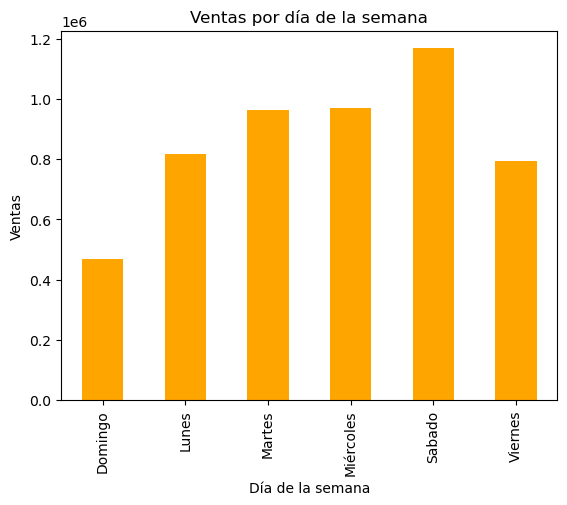

In [216]:
# Extraer el día de la semana de la venta
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

# Asignar el nombre del día de la semana a cada venta
day_mapping = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Sabado', 4: 'Viernes', 5: 'Jueves', 6: 'Domingo'}
df['DayOfWeek'] = df['DayOfWeek'].map(day_mapping)

# Agrupar las ventas por día de la semana
sales_by_day = df.groupby('DayOfWeek')['Quantity'].sum()

# Crear un gráfico de barras
sales_by_day.plot(kind='bar', color='orange')

# Establecer las etiquetas de los ejes y el título
plt.xlabel('Día de la semana')
plt.ylabel('Ventas')
plt.title('Ventas por día de la semana')
plt.show()

### **Ventas por hora del día**

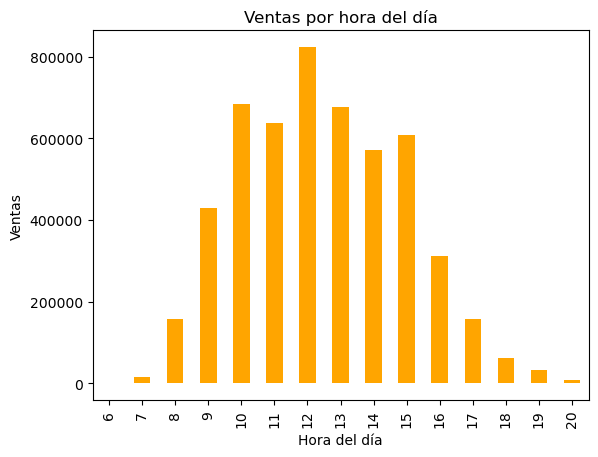

In [217]:
# Extraer la hora de la venta
df['Hour'] = df['InvoiceDate'].dt.hour

# Agrupar las ventas por hora del día
sales_by_hour = df.groupby('Hour')['Quantity'].sum()

# Crear un gráfico de barras
sales_by_hour.plot(kind='bar', color='orange')

# Establecer las etiquetas de los ejes y el título
plt.xlabel('Hora del día')
plt.ylabel('Ventas')
plt.title('Ventas por hora del día')
plt.show()

### **Día y hora con más ventas**

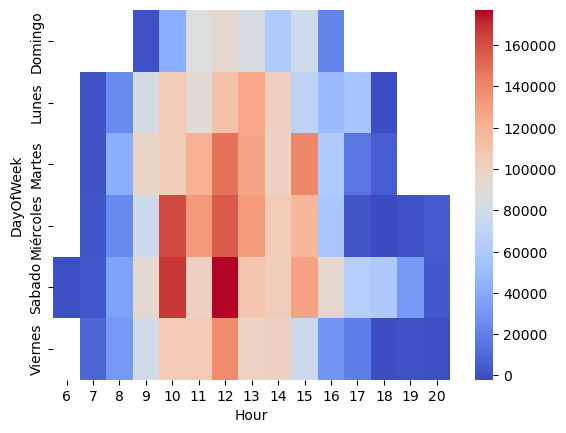

In [218]:
# Crear una tabla pivote de las ventas por día de la semana y hora del día
sales_by_day_hour = df.pivot_table(index='DayOfWeek', columns='Hour', values='Quantity', aggfunc='sum')

# Crear el heatmap
sns.heatmap(sales_by_day_hour, cmap='coolwarm')

# Mostrar el heatmap
plt.show()

- **Podemos concluir que las ventas alcanzan su punto máximo los sabados a las 12 del mediodía, según los datos analizados.**

### **Top 10 artículos más vendidos**

In [144]:
canasta = df_copy.groupby('Description').count()[['Quantity']]
canasta_clas=canasta.sort_values(by='Quantity', ascending=False)

<AxesSubplot:ylabel='Description'>

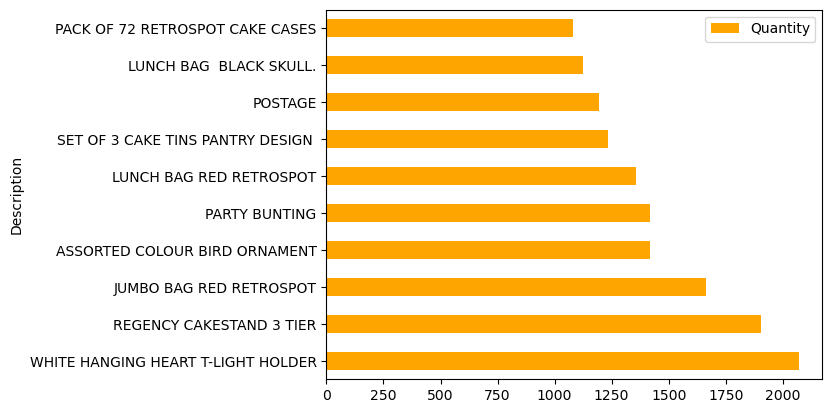

In [145]:
canasta_clas.head(10).plot.barh(color='orange')

### **Distribución de compras por país**

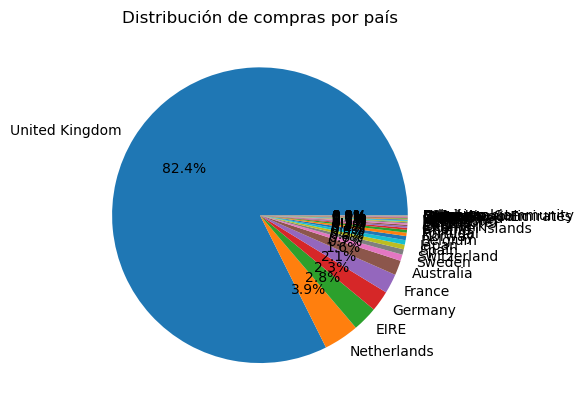

In [211]:
# Agrupar las ventas por país
sales_by_country = df.groupby('Country')['Quantity'].sum().reset_index()

# Ordenar las ventas de mayor a menor
sales_by_country = sales_by_country.sort_values(by='Quantity', ascending=False)

# Crear el gráfico de pastel
plt.pie(sales_by_country['Quantity'], labels=sales_by_country['Country'], autopct='%.1f%%')

# Añadir título al gráfico
plt.title('Distribución de compras por país')

# Mostrar el gráfico
plt.show()

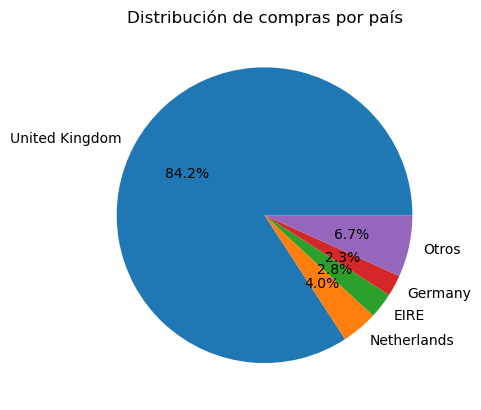

In [215]:
# Agrupar las ventas por país
sales_by_country = df.groupby('Country')['Quantity'].sum().reset_index()

# Ordenar las ventas de mayor a menor
sales_by_country = sales_by_country.sort_values(by='Quantity', ascending=False)

# Seleccionar los 5 países más representativos
top_countries = sales_by_country.head(4)

# Sumar las ventas de los países restantes y agruparlos en un nuevo DataFrame
other_countries = pd.DataFrame({
    'Country': ['Otros'],
    'Quantity': [sales_by_country['Quantity'][5:].sum()]
})

# Agregar una fila adicional al nuevo DataFrame con el total de ventas de los países restantes
top_and_other_countries = pd.concat([top_countries, other_countries])

# Crear el gráfico de pastel utilizando los nuevos datos
plt.pie(top_and_other_countries['Quantity'], labels=top_and_other_countries['Country'], autopct='%.1f%%')

# Añadir título al gráfico
plt.title('Distribución de compras por país')

# Mostrar el gráfico
plt.show()


---

---

- **Se puede observar que el Reino Unido es el país que realiza más del 80% de las compras.**

# DATA CLEANING

In [147]:
# Removemos las transacciones canceladas que son las que contienen "C"
df_copy=df_copy[~df_copy['InvoiceNo'].str.contains('C')]

In [148]:
# Eliminar duplicado de la variable InvoiceNo
df_copy.dropna(axis=0, subset= ['InvoiceNo'], inplace=True)

### **Outliers**

In [149]:
# Tratar los Outliers (Interquartile Range Method)
def outliers(factor):
    Q1 = np.percentile(df_copy[factor], 25)
    Q3 = np.percentile(df_copy[factor], 75)
    
    IQR = Q3-Q1
    max = Q3+1.5*IQR
    min = Q1-1.5*IQR
    
    print('Variable: ' + factor)
    print('Máximo aceptado: ' + str(max))
    print('Mínimo aceptado: ' + str(min))
    
    return (df_copy[(df_copy[factor]<max) & (df_copy[factor]>min)])

In [150]:
# Quitando outliers de "Quantity"
df_copy = outliers('Quantity')

Variable: Quantity
Máximo aceptado: 27.0
Mínimo aceptado: -13.0


In [151]:
# Quitando outliers de "UnitPrice"
df_copy = outliers('UnitPrice')

Variable: UnitPrice
Máximo aceptado: 7.5
Mínimo aceptado: -2.5


### **Duplicados**

In [152]:
# Remover Duplicados
print(df_copy['Description'].nunique())
print(df_copy['StockCode'].nunique())

3560
3377


In [153]:
# Duplicados StockCode
dup = df_copy[['Description', 'StockCode']].drop_duplicates()
dup = dup.groupby('Description').count()[['StockCode']]
dup = dup.reset_index()
dup.sort_values(by=('StockCode'), ascending=False).head()

,Description,StockCode
1850,"METAL SIGN,CUPCAKE SINGLE HOOK",3
1230,FROSTED WHITE BASE,2
2277,PINK FLOWERS RABBIT EASTER,2
2271,PINK FLOCK GLASS CANDLEHOLDER,2
2144,PAPER LANTERN 9 POINT SNOW STAR,2


In [154]:
dup.rename(columns={'StockCode': 'StockCode_Count'}, inplace=True)

In [155]:
dup = dup[dup['StockCode_Count']>1]

In [156]:
df_copy = df_copy[~df_copy['Description'].isin(dup['Description'])]

In [157]:
print(df_copy['Description'].nunique())
print(df_copy['StockCode'].nunique())

3541
3342


In [158]:
# Duplicados Description
dup = df_copy[['Description', 'StockCode']].drop_duplicates()
dup = dup.groupby('StockCode').count()[['Description']]
dup = dup.reset_index()
dup.sort_values(by=('Description'), ascending=False).head()

,StockCode,Description
1928,23236,4
1888,23196,4
1822,23126,3
1666,22937,3
2076,23413,3


In [159]:
dup.rename(columns={'Description': 'Description_Count'}, inplace=True)

In [160]:
dup = dup[dup['Description_Count']>1]

In [161]:
df_copy = df_copy[~df_copy['StockCode'].isin(dup['StockCode'])]

In [162]:
print(df_copy['Description'].nunique())
print(df_copy['StockCode'].nunique())

3158
3158


In [163]:
# Quitar el CP en Código del Producto
df_copy = df_copy[~df_copy['StockCode'].str.contains("POST", na=False)]

# France

**Para efectos de este proyecto, trabajaremos con los datos de "France", como proxima meta será realizar el análisis para los demás países**

In [164]:
df_copy['Country'].value_counts().head()

United Kingdom    276422
Germany             6765
France              6309
EIRE                4940
Spain               1869
Name: Country, dtype: int64

In [165]:
df_france=df_copy[df_copy['Country']=='France']

In [166]:
df_france

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,3.75,12583,France
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,3.75,12583,France
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,3.75,12583,France
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,0.85,12583,France
30,536370,21883,STARS GIFT TAPE,24,0.65,12583,France
...,...,...,...,...,...,...,...
541902,581587,22629,SPACEBOY LUNCH BOX,12,1.95,12680,France
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France


### Encoding

In [175]:
def matrix(df, id=False):
    if id:
        return df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return df.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    
    

In [176]:
productos = matrix(df_france, id=True)
productos.head()

Description,DOLLY GIRL BEAKER,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,...,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP SUKI AND FRIENDS,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC FOLKART SLEIGH BELLS,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Entrenando al modelo

- **Algoritmo Apriori** 

In [177]:
# En seguida generaremos los canasta de productos frecuentes
freq_prods = apriori(productos, min_support=0.01, use_colnames=True)
freq_prods.head()

,support,itemsets
0,0.025000,( DOLLY GIRL BEAKER)
1,0.027778,(10 COLOUR SPACEBOY PEN)
2,0.016667,(12 COLOURED PARTY BALLOONS)
3,0.016667,(12 PENCIL SMALL TUBE WOODLAND)
4,0.019444,(12 PENCILS SMALL TUBE RED RETROSPOT)


In [178]:
# Aquí se generaran las reglas de asociación
rules = association_rules(freq_prods, metric="lift", min_threshold=1)

In [179]:
# Visualizar las reglas de asociación ordenadas por la medida de lift
rules.sort_values('lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
258959,"(PLASTERS IN TIN SPACEBOY, LUNCH BOX I LOVE LO...","(MAGNETS PACK OF 4 SWALLOWS, TREASURE TIN GYMK...",0.011111,0.011111,0.011111,1.0,90.0,0.010988,inf
412341,"(PLASTERS IN TIN CIRCUS PARADE , PLASTERS IN T...","(BUNDLE OF 3 ALPHABET EXERCISE BOOKS, ROUND SN...",0.011111,0.011111,0.011111,1.0,90.0,0.010988,inf
348457,"(LUNCH BOX I LOVE LONDON, ALARM CLOCK BAKELIKE...","(ROUND SNACK BOXES SET OF4 WOODLAND , DOLLY GI...",0.011111,0.011111,0.011111,1.0,90.0,0.010988,inf
348456,"(LUNCH BOX I LOVE LONDON, LUNCH BAG APPLE DESI...","(ROUND SNACK BOXES SET OF4 WOODLAND , DOLLY GI...",0.011111,0.011111,0.011111,1.0,90.0,0.010988,inf
348455,"(LUNCH BOX I LOVE LONDON, ALARM CLOCK BAKELIKE...","(ROUND SNACK BOXES SET OF4 WOODLAND , DOLLY GI...",0.011111,0.011111,0.011111,1.0,90.0,0.010988,inf


## Proporcionando la recomendación

- En esta sección, nos enfocaremos en recomendar un producto basándonos en el producto que usted haya adquirido.

In [200]:
# Función que nos entregue los items con relación al producto adquirido.
def recom (dataframe, description, support_val=0.01, num_de_productos=3):
    recomendacion= []
    
    for idx, producto in enumerate(rules["antecedents"]):
        for j in list(producto):
            if j == description:
                recomendacion.append(list(rules.iloc[idx]["consequents"])[0])
                recomendacion = list(dict.fromkeys(recomendacion))
    return(recomendacion[0:num_de_productos])

In [197]:
pd.DataFrame(df_france['Description'].sample(5))

,Description
475980,RECYCLING BAG RETROSPOT
368468,HAIRCLIPS FORTIES FABRIC ASSORTED
180540,LUNCH BAG RED RETROSPOT
32253,FUNKY WASHING UP GLOVES ASSORTED
185811,ENCHANTED BIRD COATHANGER 5 HOOK


In [203]:
# Se ejecuta la función y lo alimentamos con un StockCode para que nos arroje los productos relacionados a el
John = recom(df_france,'SET OF 20 KIDS COOKIE CUTTERS')
Mary = recom(df_france, 'RETROSPOT LARGE MILK JUG')
Cam = recom(df_france, 'ALARM CLOCK BAKELIKE PINK')

print(f'Productos sugeridos en función del Artículo comprado {John}')
print(f'Productos sugeridos en función del Artículo comprado {Mary}')
print(f'Productos sugeridos en función del Artículo comprado {Cam}')

Productos sugeridos en función del Artículo comprado ['PLASTERS IN TIN CIRCUS PARADE ', "POPPY'S PLAYHOUSE KITCHEN", 'RETROSPOT TEA SET CERAMIC 11 PC ']
Productos sugeridos en función del Artículo comprado ['RED RETROSPOT BUTTER DISH', 'RED RETROSPOT SMALL MILK JUG', 'RED RETROSPOT SUGAR JAM BOWL']
Productos sugeridos en función del Artículo comprado ['ALARM CLOCK BAKELIKE CHOCOLATE', 'ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE IVORY']


In [204]:
def recom(dataframe, description, support_val=0.01, num_de_productos=3):
    recomendacion = []

    for idx, producto in enumerate(rules["antecedents"]):
        for j in list(producto):
            if j == description:
                recomendacion.append(list(rules.iloc[idx]["consequents"])[0])
                recomendacion = list(dict.fromkeys(recomendacion))

    print(f"Productos sugeridos en función del artículo comprado '{description}':")
    for i, producto in enumerate(recomendacion[0:num_de_productos]):
        print(f"{i+1}. {producto}")


In [207]:
recom(df_france, 'SET OF 20 KIDS COOKIE CUTTERS')
print("")
recom(df_france, 'RETROSPOT LARGE MILK JUG')
print("")
recom(df_france, 'ALARM CLOCK BAKELIKE PINK')

Productos sugeridos en función del artículo comprado 'SET OF 20 KIDS COOKIE CUTTERS':
1. PLASTERS IN TIN CIRCUS PARADE 
2. POPPY'S PLAYHOUSE KITCHEN
3. RETROSPOT TEA SET CERAMIC 11 PC 

Productos sugeridos en función del artículo comprado 'RETROSPOT LARGE MILK JUG':
1. RED RETROSPOT BUTTER DISH
2. RED RETROSPOT SMALL MILK JUG
3. RED RETROSPOT SUGAR JAM BOWL

Productos sugeridos en función del artículo comprado 'ALARM CLOCK BAKELIKE PINK':
1. ALARM CLOCK BAKELIKE CHOCOLATE
2. ALARM CLOCK BAKELIKE GREEN
3. ALARM CLOCK BAKELIKE IVORY


In [208]:
def recom(dataframe, support_val=0.01, num_de_productos=3):
    descripcion = input("Ingrese el nombre del producto: ")
    recomendacion = []

    for idx, producto in enumerate(rules["antecedents"]):
        for j in list(producto):
            if j == descripcion:
                recomendacion.append(list(rules.iloc[idx]["consequents"])[0])
                recomendacion = list(dict.fromkeys(recomendacion))

    print(f"Productos sugeridos en función del artículo comprado '{descripcion}':")
    for i, producto in enumerate(recomendacion[0:num_de_productos]):
        print(f"{i+1}. {producto}")

- SET OF 20 KIDS COOKIE CUTTERS
- RETROSPOT LARGE MILK JUG
- ALARM CLOCK BAKELIKE PINK

In [232]:
recom(df_france)

Ingrese el nombre del producto:  ALARM CLOCK BAKELIKE PINK


Productos sugeridos en función del artículo comprado 'ALARM CLOCK BAKELIKE PINK':
1. ALARM CLOCK BAKELIKE CHOCOLATE
2. ALARM CLOCK BAKELIKE GREEN
3. ALARM CLOCK BAKELIKE IVORY
